## EN3160 Assignment 2 on Fitting and Alignment
### Name:  Kavinda W.M.C.
### Index: 200301D

Import Libraries

In [20]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.ndimage import maximum_filter
from scipy.optimize import minimize
from scipy import linalg
import tikzplotlib

Question 1

Parameters of the Largest Circle:
Center: (1341, 627)
Radius: 42
Range of Sigma Values Used: 5.0 to 30.0


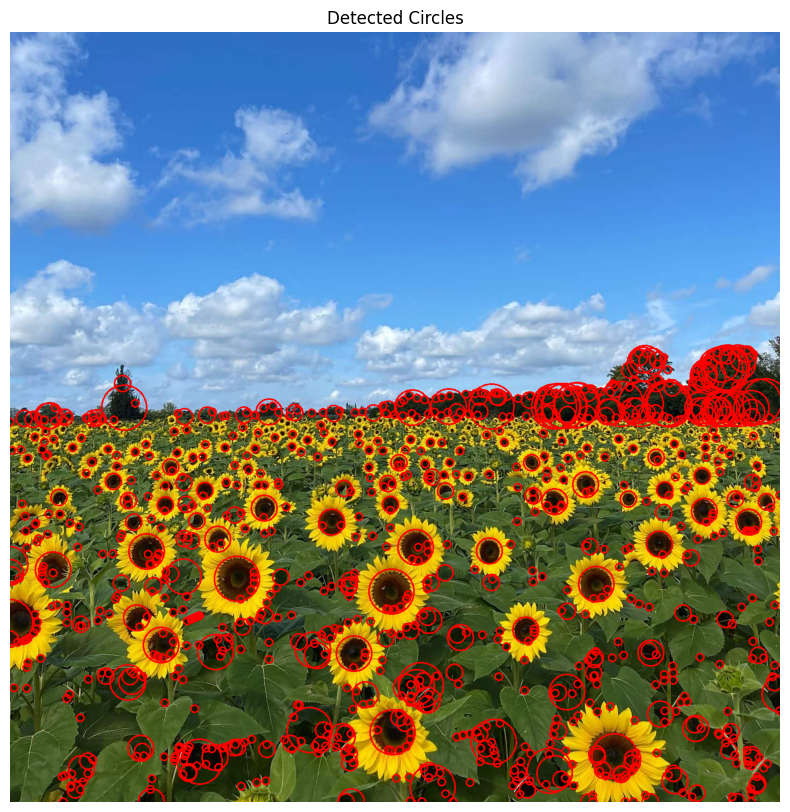

In [7]:
im = cv.imread('Images/the_berry_farms_sunflower_field.jpeg', cv.IMREAD_COLOR)

gray_im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)

# Define range of sigma values
sigma_values = np.linspace(5, 30, 5)

scale_space = []

for sigma in sigma_values:
    kernel_size = int(4 * sigma) + 1
    kernel_hw = kernel_size // 2
    X, Y = np.meshgrid(np.arange(-kernel_hw, kernel_hw + 1), np.arange(-kernel_hw, kernel_hw + 1))
    log_kernel = (X ** 2 + Y ** 2 - 2 * sigma ** 2) * np.exp(-(X ** 2 + Y ** 2) / (2 * sigma ** 2))

    # Apply LoG filtering to the grayscale image
    log_response = cv.filter2D(gray_im.astype(np.float32), -1, log_kernel)

    # Store the result in the scale space
    scale_space.append(log_response)

# Convert the scale space to a numpy array
scale_space = np.array(scale_space)

local_maxima = maximum_filter(scale_space, size=(3, 3, 3))

maxima_coordinates = np.argwhere((scale_space == local_maxima) & (local_maxima > 0))

detected_circles = []

for coord in maxima_coordinates:
    z, y, x = coord
    radius = int(np.sqrt(2)* sigma_values[z])
    center = (x, y)
    detected_circles.append((center, radius))

largest_circle = max(detected_circles, key=lambda x: x[1])
largest_center, largest_radius = largest_circle
print("Parameters of the Largest Circle:")
print("Center:", largest_center)
print("Radius:", largest_radius)
print("Range of Sigma Values Used:", sigma_values[0], "to", sigma_values[-1])

# Draw detected circles on the original image
output_image = im.copy()
for circle in detected_circles:
    center, radius = circle
    cv.circle(output_image, center, radius, (0, 0, 255), 2)

output_image_rgb = cv.cvtColor(output_image, cv.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(output_image_rgb)
plt.title("Detected Circles")
plt.axis('off')
plt.show()


Question 2

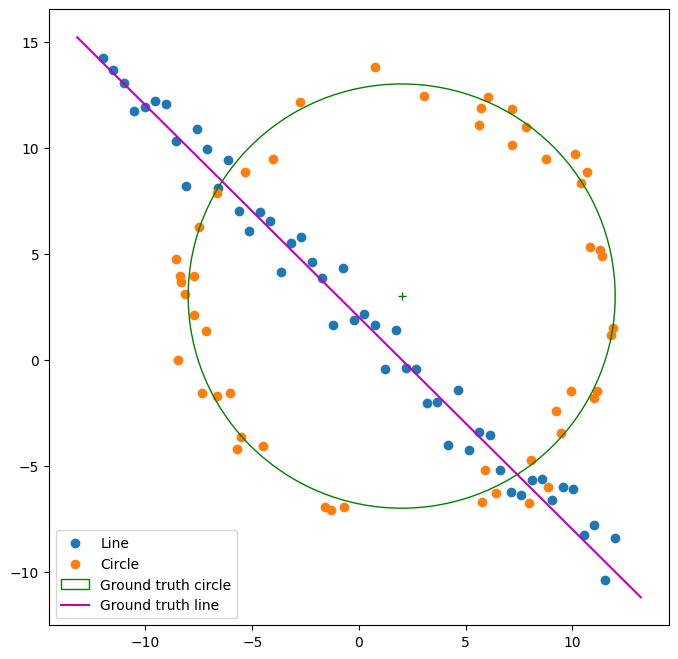

In [17]:
# np.random.seed(0)
N = 100
half_n = N // 2

r = 10
x0_gt, y0_gt = 2, 3  # Center
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s = 1.
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
X = np.vstack((X_circ, X_line))  # All points

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')
plt.legend()


Question 2(a)

Best line model [0.70386701 0.71033179 1.64418734]


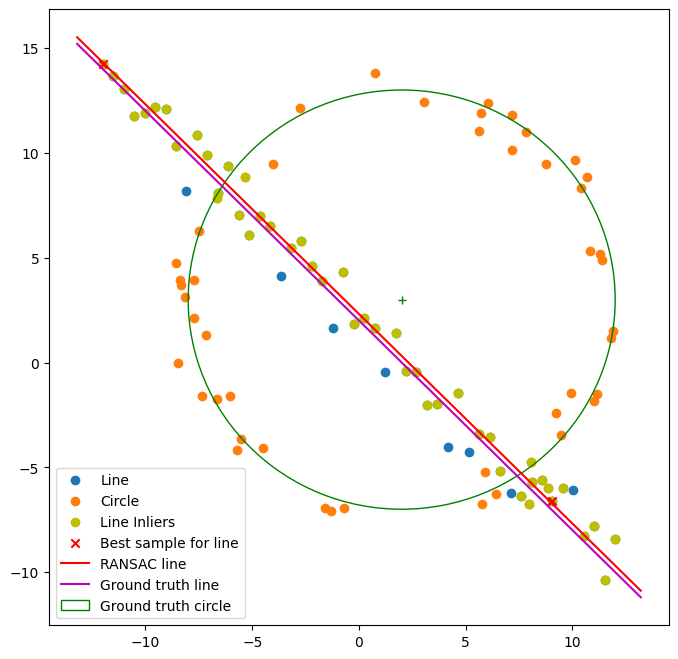

In [18]:
import math
N=X.shape[0]
X_=X
def line_equation_from_points(x1, y1, x2, y2):
    delta_x = x2 - x1
    delta_y = y2 - y1
    magnitude = math.sqrt(delta_x**2 + delta_y**2)
    a = delta_y / magnitude
    b = -delta_x / magnitude
    d = (a * x1) + (b * y1)
    # Return the line equation in the form ax + by = d
    return a, b, d

# RANSAC to fit a line
def line_tls(x, indices):
    a, b, d = x[0], x[1], x[2]
    return np.sum(np.square(a*X_[indices,0] + b*X_[indices,1] - d))

# Constraint
def g(x):
    return x[0]**2 + x[1]**2 - 1

cons = ({'type': 'eq', 'fun': g})

# Computing the consensus (inliers)
def consensus_line(X_, x, t):
    a, b, d = x[0], x[1], x[2]
    error = np.absolute(a*X_[:,0] + b*X_[:,1] - d)
    return error < t

t = 1.   # Threshold value to determine data points that are fit well by model.
d = 0.4*N   # Number of close data points required to assert that a model fits well to data.
s = 2       # Minimum number of data points required to estimate model parameters.

inliers_line = []        # Indinces of the inliers
max_iterations = 200
iteration = 0
best_model_line = []     # Best model normal (a, b) and distance from origin d
best_error = np.inf
best_sample_line = []    # Three-point sample leading to the best model computation
res_only_with_sample = [] # Result (a, b, d) only using the best sample
best_inliers_line = []   # Inliers of the model computed form the best sample

while iteration < max_iterations:   
    indices = np.random.randint(0, N, s) # A sample of three (s) points selected at random
    x0 = np.array([1, 1, 0]) # Initial estimate
    res = minimize(fun = line_tls, args = indices, x0 = x0, tol= 1e-6, constraints=cons, options={'disp': False})
    inliers_line = consensus_line(X_, res.x, t) # Computing the inliers
    #print('rex.x: ', res.x)    
    #print('Iteration = ', iteration, '. No. inliners = ', inliers_line.sum())
    if inliers_line.sum() > d:
        x0 = res.x
        # Computing the new model using the inliers
        res = minimize(fun = line_tls, args = inliers_line, x0 = x0, tol= 1e-6, constraints=cons, options={'disp': False})
        #print(res.x, res.fun)
        if res.fun < best_error:
            #print('A better model found ... ', res.x, res.fun)
            best_model_line = res.x
            best_eror = res.fun
            best_sample_line = X_[indices,:]
            res_only_with_sample = x0
            best_inliers_line = inliers_line

    iteration += 1

print('Best line model', best_model_line)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')
ax.scatter(X_[best_inliers_line,0],X_[best_inliers_line,1], color='y', label='Line Inliers')
ax.scatter(best_sample_line[:,0],best_sample_line[:,1], marker='x', color='r', label='Best sample for line')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
y_est = (-best_model_line[1]*x_ + best_model_line[2])/best_model_line[1]
plt.plot(x_, y_est, color='r', label='RANSAC line')
plt.plot(x_, y_, color='m', label='Ground truth line')
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')
plt.legend()
plt.show()



Question 2(b)

In [19]:
remaining_points=X
if best_inliers_line is not None:
    remaining_points= remaining_points[best_inliers_line, :]

def circle_consensus(data, model,t):
    center_x, center_y, radius = model
    distances = np.sqrt((data[:, 0] - center_x)**2 + (data[:, 1] - center_y)**2)
    inliers = np.abs(distances - radius) < t
    return inliers

def circle_tls(x, indices, remaining_points):
    x_center, y_center, r = x[0], x[1], x[2]
    # Calculate the squared differences between the distances and the circle's radius
    squared_errors = np.sqrt((remaining_points[indices, 0] - x_center)**2 + (remaining_points[indices, 1] - y_center)**2 )
    # Return the sum of squared errors
    return np.sum(np.abs(squared_errors-r))

distance_treshold=0.8
con_c={'type': 'ineq', 'fun': lambda x: x[2] - distance_treshold}

def ransac_circle(X, t, iter, in_t):
    n = X.shape[0]
    best_error = np.inf
    best_sample_circle = []  
    res_only_with_sample = [] 
    best_inliers_circle = []   

    for i in range(iter):
        indices = np.random.choice(n, 3, replace=False)
        x0 = [1, 1, 1]
        res = minimize(fun=circle_tls, args=(indices,X), x0=x0, tol=1e-6, constraints=con_c, options={'disp': False})
        inliers = circle_consensus(X, res.x, t)
        n_inliers = np.sum(inliers)
        if n_inliers > in_t:
            x0 = res.x
            res = minimize(fun=circle_tls, args=(inliers,X), x0=x0, tol=1e-6, constraints=con_c, options={'disp': False})
            if res.fun < best_error:
                best_error = res.fun
                best_inliers_circle = inliers
                best_x_center, best_y_center, best_r = res.x
                best_sample_circle = indices
                res_only_with_sample = x0

    return best_x_center, best_y_center, best_r, best_inliers_circle, best_sample_circle, res_only_with_sample

best_x_center, best_y_center, best_r, best_inliers_circle, best_sample_circle, res_only_with_sample = ransac_circle(X_circ, distance_treshold, 200, 0.8 * remaining_points.shape[0])


Question 2(c)

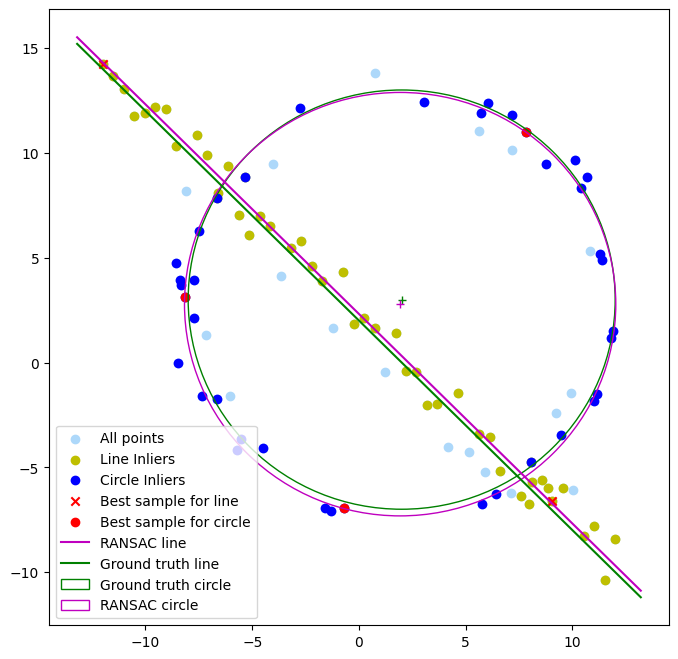

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
light_blue = (173/255, 216/255, 250/255)
ax.scatter(X[:, 0], X[:, 1], color=light_blue, label='All points')
ax.scatter(X_[best_inliers_line,0],X_[best_inliers_line,1], color='y', label='Line Inliers')
ax.scatter(X_circ[best_inliers_circle, 0], X_circ[best_inliers_circle, 1], color='b', label='Circle Inliers')
ax.scatter(best_sample_line[:,0],best_sample_line[:,1], marker='x', color='r', label='Best sample for line')
ax.scatter(X_circ[best_sample_circle, 0], X_circ[best_sample_circle, 1], color='r', label='Best sample for circle')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
y_est = (-best_model_line[1]*x_ + best_model_line[2])/best_model_line[1]
plt.plot(x_, y_est, color='m', label='RANSAC line')
plt.plot(x_, y_, color='g', label='Ground truth line')
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')
# Estimated circle
circle_est = plt.Circle((best_x_center, best_y_center), best_r, color='m', fill=False, label='RANSAC circle')
ax.add_patch(circle_est)
ax.plot(best_x_center, best_y_center, '+', color='m')
plt.legend()
plt.show()

In [21]:
print(best_x_center, best_y_center, best_r)

1.9282375490896768 2.782853869927144 10.100422734529385


Question 3

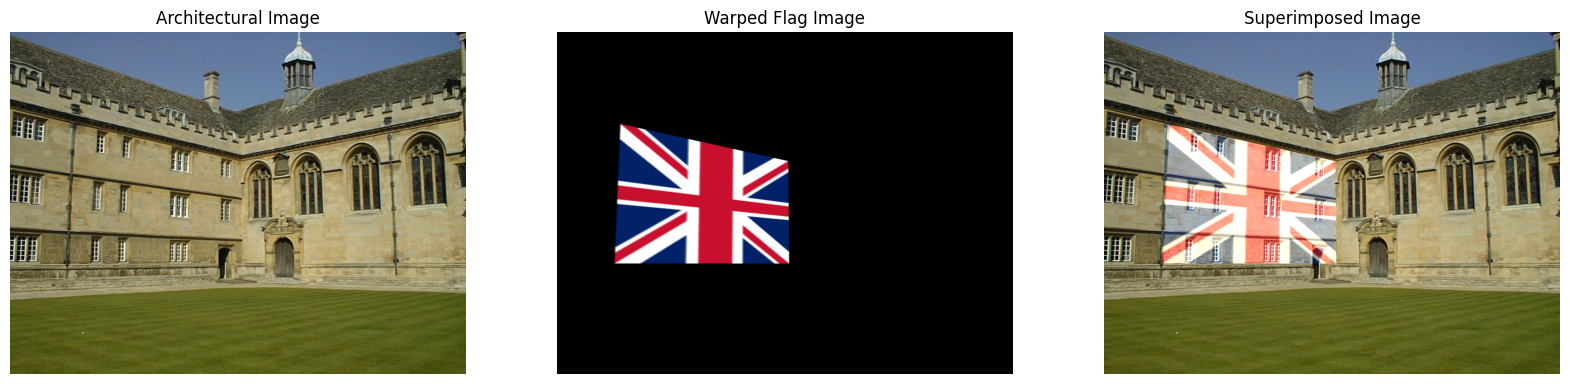

In [40]:
corner_points = []

def click_event(event, x, y, flags, param):
    global corner_points
    if event == cv.EVENT_LBUTTONDOWN:
        corner_points.append((x, y))
        cv.circle(architectural_image1, (x, y), 5, (0, 0, 255), -1)
        cv.imshow('Architectural Image', architectural_image1)

        if len(corner_points) == 4:
            cv.destroyAllWindows()

architectural_image1 = cv.imread('Images/architectural image.jpg', cv.IMREAD_COLOR)
flag_image1 = cv.imread('Images/Flag_of_the_United_Kingdom.png', cv.IMREAD_COLOR)

architectural_imaga_rgb = cv.cvtColor(architectural_image1, cv.COLOR_BGR2RGB)

# Display the architectural image and set a mouse callback function
cv.imshow('Architectural Image', architectural_image1)
cv.setMouseCallback('Architectural Image', click_event)
cv.waitKey(0)

pts_architecture = np.array(corner_points, dtype=np.float32)
pts_flag = np.array([[0, 0], [flag_image1.shape[1], 0], [flag_image1.shape[1], flag_image1.shape[0]], [0, flag_image1.shape[0]]], dtype=np.float32)

homography_matrix, _ = cv.findHomography(pts_flag, pts_architecture)

# Warp the flag image
flag_warped = cv.warpPerspective(flag_image1, homography_matrix, (architectural_image1.shape[1], architectural_image1.shape[0]))
flag_warped_rgb = cv.cvtColor(flag_warped, cv.COLOR_BGR2RGB)

alpha1 = 0.6

superimposed_image = cv.addWeighted(architectural_imaga_rgb, 1, flag_warped_rgb, alpha1, 0)

# Display the images
plt.figure(figsize=(20, 15))
plt.subplot(1, 3, 1)
plt.imshow(architectural_imaga_rgb)
plt.title('Architectural Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(flag_warped_rgb)
plt.title('Warped Flag Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(superimposed_image)
plt.title('Superimposed Image')
plt.axis('off')
plt.show()


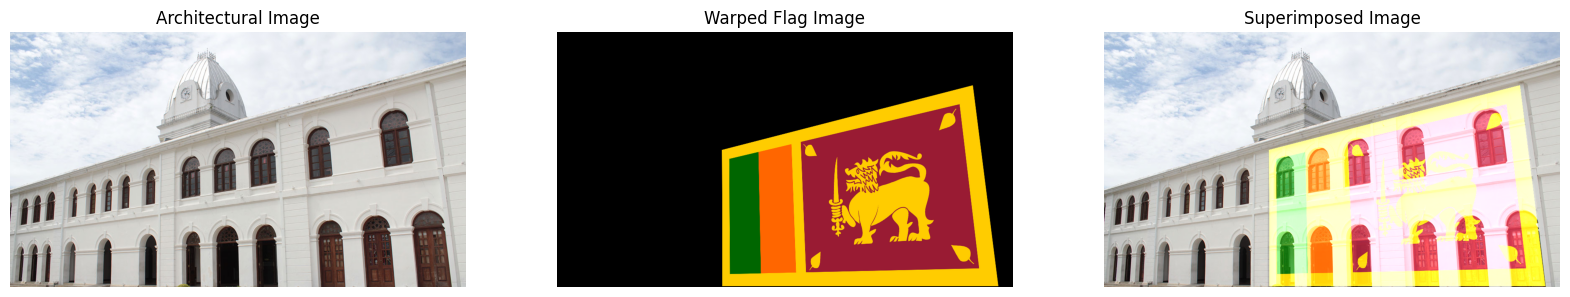

In [41]:
corner_points = []

def click_event(event, x, y, flags, param):
    global corner_points
    if event == cv.EVENT_LBUTTONDOWN:
        corner_points.append((x, y))
        cv.circle(architectural_image2, (x, y), 5, (0, 0, 255), -1)
        cv.imshow('Architectural Image', architectural_image2)

        if len(corner_points) == 4:
            cv.destroyAllWindows()

architectural_image2 = cv.imread('Images/independence-arcade.jpg', cv.IMREAD_COLOR)
flag_image2 = cv.imread('Images/flag.png', cv.IMREAD_COLOR)

architectural_imaga_rgb = cv.cvtColor(architectural_image2, cv.COLOR_BGR2RGB)

# Display the architectural image and set a mouse callback function
cv.imshow('Architectural Image', architectural_image2)
cv.setMouseCallback('Architectural Image', click_event)
cv.waitKey(0)

pts_architecture = np.array(corner_points, dtype=np.float32)
pts_flag = np.array([[0, 0], [flag_image2.shape[1], 0], [flag_image2.shape[1], flag_image2.shape[0]], [0, flag_image2.shape[0]]], dtype=np.float32)

homography_matrix, _ = cv.findHomography(pts_flag, pts_architecture)

# Warp the flag image
flag_warped = cv.warpPerspective(flag_image2, homography_matrix, (architectural_image2.shape[1], architectural_image2.shape[0]))
flag_warped_rgb = cv.cvtColor(flag_warped, cv.COLOR_BGR2RGB)

alpha2 = 1

superimposed_image = cv.addWeighted(architectural_imaga_rgb, 1, flag_warped_rgb, alpha2, 0)

# Display the images
plt.figure(figsize=(20, 15))
plt.subplot(1, 3, 1)
plt.imshow(architectural_imaga_rgb)
plt.title('Architectural Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(flag_warped_rgb)
plt.title('Warped Flag Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(superimposed_image)
plt.title('Superimposed Image')
plt.axis('off')
plt.show()


Question 4

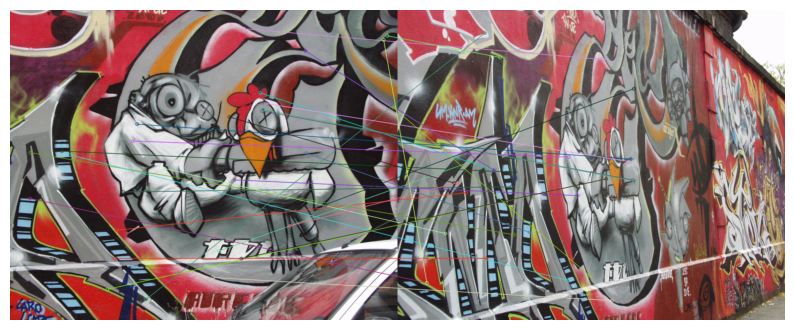

In [42]:
# Import images
img1 = cv.imread('Images/img1.ppm')  
img5 = cv.imread('Images/img5.ppm')

# Create a SIFT detector
sift = cv.SIFT_create()

# Find key points and descriptors in both images
keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints5, descriptors5 = sift.detectAndCompute(img5, None)

# Create a Brute Force Matcher
bf = cv.BFMatcher()

matches = bf.knnMatch(descriptors1, descriptors5, k=2)

good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

matched_img = cv.drawMatchesKnn(img1, keypoints1, img5, keypoints5, [good_matches], None, flags=2)
matched_img=cv.cvtColor(matched_img, cv.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(matched_img)
plt.axis('off')
plt.show()

In [43]:
img1 = cv.imread("Images/img1.ppm")
img2 = cv.imread("Images/img2.ppm")
img3 = cv.imread("Images/img3.ppm")
img4 = cv.imread("Images/img4.ppm")
img5 = cv.imread("Images/img5.ppm")

image1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
image2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)
image3 = cv.cvtColor(img3, cv.COLOR_BGR2GRAY)
image4 = cv.cvtColor(img4, cv.COLOR_BGR2GRAY)
image5 = cv.cvtColor(img5, cv.COLOR_BGR2GRAY)

img_list = [image1, image2, image3, image4, image5]

def random_indices(n, t):
    random_num = np.random.randint(n, size=t)
    counts = np.zeros(np.shape(random_num))
    
    for i in range(len(random_num)):
        counts[i] = np.sum(random_num==random_num[i])
    if np.sum(counts) == len(counts):
        return random_num
    else:
        return random_indices(n,t)

def Compute_Homography(src_points, dest_points):
    x1, y1, x2, y2, x3, y3, x4, y4 = dest_points[0], dest_points[1], dest_points[2], dest_points[3], dest_points[4], dest_points[5], dest_points[6], dest_points[7] 
    x1T, x2T, x3T, x4T = src_points[0], src_points[1], src_points[2], src_points[3]
    zero_matrix = np.array([[0], [0], [0]])

    matrix_A = np.concatenate((np.concatenate((zero_matrix.T,x1T, -y1*x1T), axis = 1), np.concatenate((x1T, zero_matrix.T, -x1*x1T), axis = 1),
                            np.concatenate((zero_matrix.T,x2T, -y2*x2T), axis = 1), np.concatenate((x2T, zero_matrix.T, -x2*x2T), axis = 1),
                            np.concatenate((zero_matrix.T,x3T, -y3*x3T), axis = 1), np.concatenate((x3T, zero_matrix.T, -x3*x3T), axis = 1),
                            np.concatenate((zero_matrix.T,x4T, -y4*x4T), axis = 1), np.concatenate((x4T, zero_matrix.T, -x4*x4T), axis = 1)), axis = 0, dtype=np.float64)
    W, v = np.linalg.eig(((matrix_A.T) @ matrix_A))
    temph= v[:,np.argmin(W)]
    H = temph.reshape((3,3))
    return H

probability = 0.999
sample_size = 4
epsilon = 0.5

N = int(np.ceil(np.log(1-probability) / np.log(1-((1-epsilon)**sample_size))))
H_list = []

for i in range(4):
    sift = cv.SIFT_create()
    keypoints1, descriptors1 = sift.detectAndCompute(img_list[i],None)
    keypoints2, descriptors2 = sift.detectAndCompute(img_list[i+1],None)
    bf_match = cv.BFMatcher(cv.NORM_L1, crossCheck=True)  
    matches = sorted(bf_match.match(descriptors1, descriptors2), key = lambda x:x.distance)
    Src_Points = [keypoints1[k.queryIdx].pt for k in matches]
    Dest_Points = [keypoints2[k.trainIdx].pt for k in matches]
    threshold, best_inliers, best_H = 2, 0, 0

    for i in range(N):
        random_points = random_indices(len(Src_Points)-1, 4)

        src_points = []
        for j in range(4):
            src_points.append(np.array([[Src_Points[random_points[j]][0], Src_Points[random_points[j]][1], 1]]))

        dest_points = []
        for j in range(4):
            dest_points.append(Dest_Points[random_points[j]][0]) 
            dest_points.append(Dest_Points[random_points[j]][1])

        H = Compute_Homography(src_points, dest_points)
        inliers = 0 

        for k in range(len(Src_Points)):
            X = [Src_Points[k][0], Src_Points[k][1], 1]
            HX = H @ X
            HX /= HX[-1]
            err = np.sqrt(np.power(HX[0]-Dest_Points[k][0], 2) + np.power(HX[1]-Dest_Points[k][1], 2))

            if err < threshold:
                inliers +=1

        if inliers > best_inliers:
            best_inliers = inliers
            best_H = H

    H_list.append(best_H)

H1_to_H5 = H_list[3] @ H_list[2] @ H_list[1] @ H_list[0]
H1_to_H5 /= H1_to_H5[-1][-1]

print("Homography")
print(H1_to_H5)

Homography
[[ 6.13931730e-01  3.62478058e-02  2.24307445e+02]
 [ 2.18446715e-01  1.12279099e+00 -2.08646458e+01]
 [ 4.84866494e-04 -1.04989860e-04  1.00000000e+00]]


Text(0.5, 1.0, 'Stitched Image')

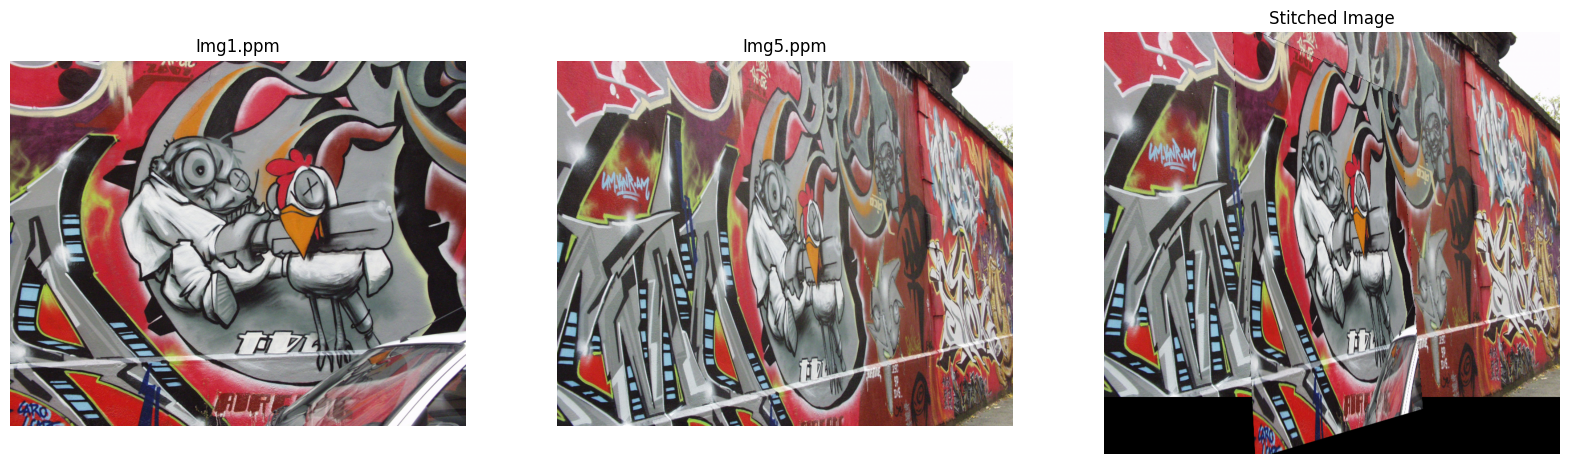

In [44]:
final_img = cv.warpPerspective(img1, H1_to_H5, dsize=(img1.shape[1], img1.shape[0]+100))

for i in range(final_img.shape[0]):
    for j in range(final_img.shape[1]):
        if np.all(final_img[i,j] == 0) and i < img5.shape[0] and j < img5.shape[1]:
            final_img[i,j] = img5[i,j]

fig, ax = plt.subplots(1, 3, figsize=(20, 15))

ax[0].imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
ax[0].axis("off")
ax[0].set_title("Img1.ppm")
ax[1].imshow(cv.cvtColor(img5, cv.COLOR_BGR2RGB))
ax[1].axis("off")
ax[1].set_title("Img5.ppm")
ax[2].imshow(cv.cvtColor(final_img, cv.COLOR_BGR2RGB))
ax[2].axis("off")
ax[2].set_title("Stitched Image")